In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from tqdm import trange

In [2]:
sys.path.append('/home/raffaele/Documents/ml-project/src/')

In [3]:
from torch_utility import *

## Import Dataset

In [4]:
data = np.genfromtxt('/home/raffaele/Documents/ml-project/cup/ML-CUP20-TR.csv', delimiter=',', dtype=np.float64)
X = data[:, 1:-2]
y = data[:, -2:]

In [5]:
print(X.shape)
print(y.shape)

(1524, 10)
(1524, 2)


### Split train set and Validation Set

In [6]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.20, random_state=42)

In [7]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xval.shape)
print(yval.shape)

(1219, 10)
(1219, 2)
(305, 10)
(305, 2)


In [8]:
BATCH_SIZE = 128

In [9]:
train_dataset = TensorDataset(torch.Tensor(Xtrain), torch.Tensor(ytrain))
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
# train_loader = DataLoader(train_dataset, shuffle=True)

## Define Models

In [10]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(10,40)
        self.hidden1 = nn.Linear(40,20)
        self.output = nn.Linear(20,2)

    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        x = torch.relu(self.hidden1(x))
        x = self.output(x)
        return x

In [11]:
net = Net()
print(net)

Net(
  (input_layer): Linear(in_features=10, out_features=40, bias=True)
  (hidden1): Linear(in_features=40, out_features=20, bias=True)
  (output): Linear(in_features=20, out_features=2, bias=True)
)


In [12]:
def train(net, optimizer, epochs=100, val_split=None):
    loss_list = []
    acc_list = []
    val_loss_list = []
    val_acc_list = []
    history = {"loss" : loss_list, "acc" : acc_list,
               "val_loss": val_loss_list, "val_acc" : val_acc_list}
    
#     optimizer = optim.SGD(net.parameters(),lr = 0.01,momentum = 0.)
#     criterion = nn.MSELoss()
    
    if (len(val_split) == 2):
        test_dataset = TensorDataset(torch.Tensor(val_split[0]), torch.Tensor(val_split[1]))
        test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True)
#         test_loader = DataLoader(test_dataset, shuffle=True)
    
    for epoch in (t := trange(epochs)):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            out = net(inputs)
            loss = MEE(out, targets)
#             loss = nn.MSELoss(out, targets)
            loss.backward()
            optimizer.step()
            
        acc,_ = evaluate(net, train_loader, verbose=False)
        val_acc, val_loss = evaluate(net, test_loader, verbose=False, criterion=True)
        val_loss_list.append(val_loss)
        loss_list.append(loss)
        acc_list.append(acc)
        val_acc_list.append(val_acc)
        t.set_description('epoch %d/%d loss=%.5f acc=%.2f val_loss=%.5f val_acc=%.2f'
                          %(epoch+1, epochs, loss.item(), acc, val_loss, val_acc))    
            
    return history

In [13]:
def evaluate(net, test_loader, verbose=True, criterion=False):
    correct = 0
    total = 0
    loss = 0

    with torch.no_grad():
        for data in test_loader:
            X,y = data
            output = net(X)
            if (criterion):
                    loss = MEE(output, y)
#                     loss = nn.MSELoss(out, targets)
            for idx, i in enumerate(output):
#                 pred = torch.round(torch.max(i))
                pred = output[idx]
#                 print(pred)
#                 print(y[idx])
#                 print(pred)
#                 print(y[idx])
                if ((pred == y[idx]).all()):
                    correct+=1
                total+=1
    if verbose:
        print("Accuracy: ", round(correct/total, 2))
#     print(correct)
    return round(correct/total, 2), loss

### Initialize the weights

In [14]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)
        
net.apply(init_weights)

Net(
  (input_layer): Linear(in_features=10, out_features=40, bias=True)
  (hidden1): Linear(in_features=40, out_features=20, bias=True)
  (output): Linear(in_features=20, out_features=2, bias=True)
)

In [15]:
def MEE(y_real, y_pred): 
    return torch.div(torch.sum(F.pairwise_distance(y_real, y_pred, p=2)), len(y_real))

In [16]:
optimizer = optim.SGD(net.parameters(),lr = 0.001, momentum = 0.9, weight_decay=0.00001)

In [17]:
history = train(net, epochs=1000, optimizer=optimizer, val_split=(Xval, yval))

epoch 1000/1000 loss=1.84236 acc=0.00 val_loss=3.67288 val_acc=0.00: 100%|██████████| 1000/1000 [01:19<00:00, 12.64it/s]


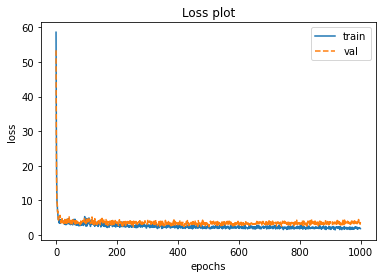

In [18]:
plot_loss(history)

In [19]:
data = [
    history['loss'][-1],
    history['acc'][-1],
    history['val_loss'][-1],
    history['val_acc'][-1],
]
table_info(data)

	    MSE     Accuracy
-----------------------------
Train	|1.8423622|	0.00|
Test	|3.6728804|	0.00|


In [20]:
to_predict = torch.tensor(list(Xval), dtype=torch.float, requires_grad=False)
out = net(to_predict)

In [21]:
out = out.detach().numpy()

In [22]:
x = out[:,0]
y = out[:,1]

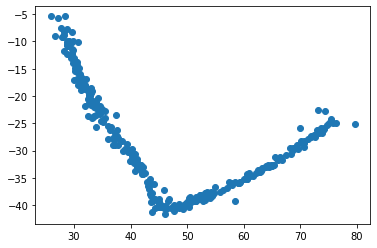

In [23]:
plt.scatter(x,y)